# 프로젝트: 폐렴 진단기 성능개선

## Step 1. 실험환경 Set-up

In [1]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

IMAGE_SIZE = [180, 180]

TRAIN_PATH = './data/train/*/*'
VAL_PATH = './data/val/*/*'
TEST_PATH = './data/test/*/*'

BATCH_SIZE = 16
EPOCHS = 6

## Step 2. 데이터 준비하기

In [3]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [4]:
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [5]:
COUNT_NORMAL = len([filename for filename in train_filenames if 'NORMAL' in filename])
print(COUNT_NORMAL)

COUNT_PNEUMONIA = len([filename for filename in train_filenames if 'PNEUMONIA' in filename])
print(COUNT_PNEUMONIA)

1070
3115


In [6]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [7]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(TRAIN_IMG_COUNT)

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(VAL_IMG_COUNT)

4185
1047


In [8]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == 'PNEUMONIA'

In [9]:
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, IMAGE_SIZE)
    return img


def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [10]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [11]:
for image, label in train_ds.take(1):
    print(f'image: {image.numpy().shape}')
    print(f'label: {label.numpy()}')

image: (180, 180, 3)
label: False


In [12]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [13]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_basic_ds = prepare_for_training(train_ds)
val_basic_ds = prepare_for_training(val_ds)

In [14]:
# Augmentation
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    return image, label

    
def prepare_for_training_aug(ds, shuffle_buffer_size=1000):
    ds = ds.map(
        augment,
        num_parallel_calls=2
    )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_aug_ds = prepare_for_training_aug(train_ds)
val_aug_ds = prepare_for_training_aug(val_ds) 

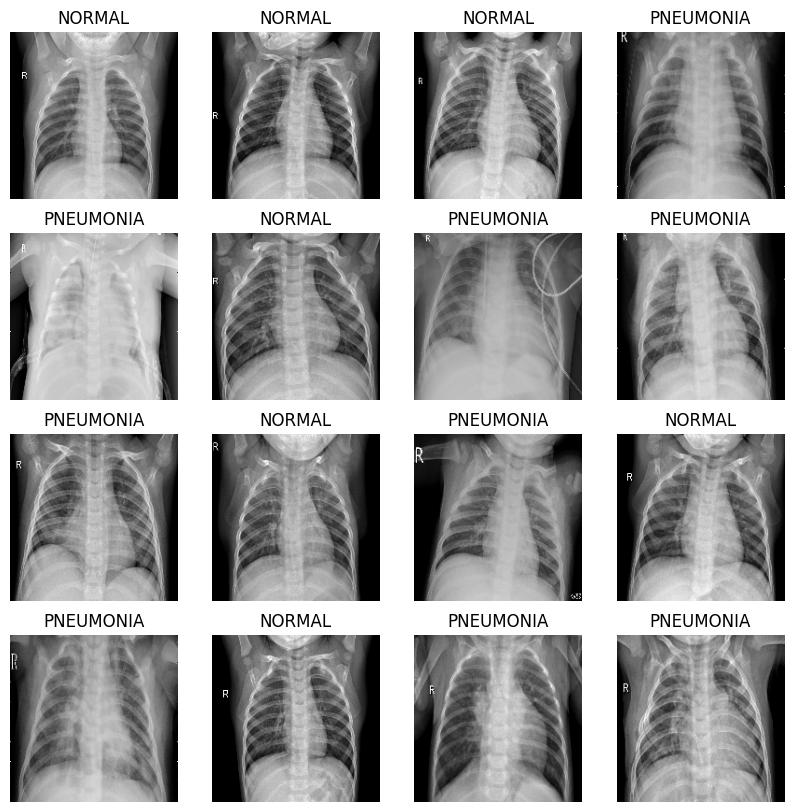

In [15]:
# Visualizaton(no agumentation)
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_basic_batch, label_basic_batch = next(iter(train_basic_ds))
show_batch(image_basic_batch.numpy(), label_basic_batch.numpy())

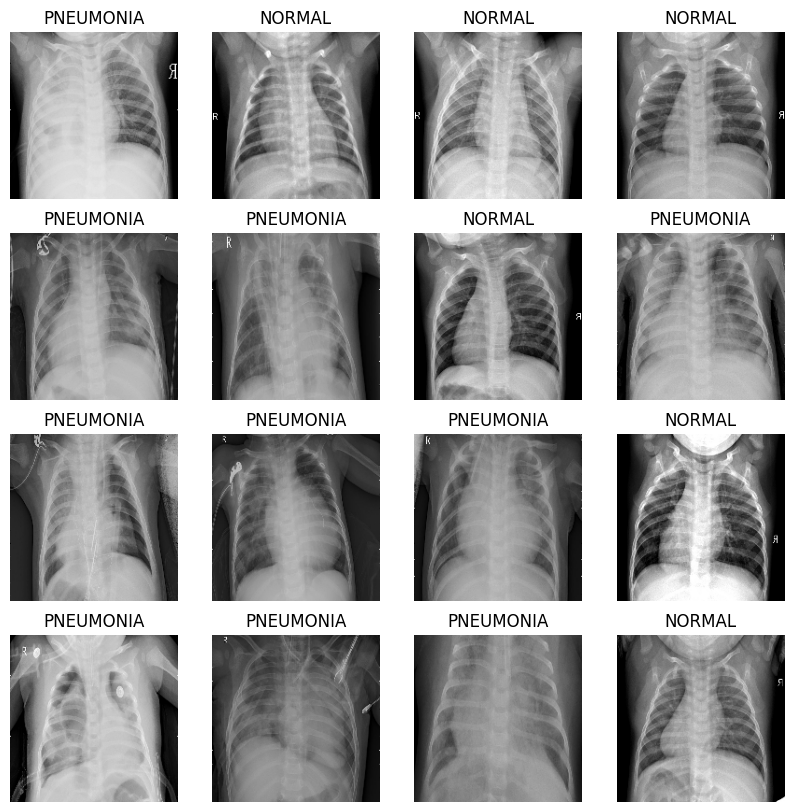

In [16]:
# Visualization(agumentation)
image_aug_batch, label_aug_batch = next(iter(train_aug_ds))
show_batch(image_aug_batch.numpy(), label_aug_batch.numpy())

## Step 4. ResNet-18 구현

In [17]:
class ResidualBlock(tf.keras.Model):
    def __init__(self, channels, down_sample=False):
        super(ResidualBlock, self).__init__()
        self.channels = channels
        self.down_sample = down_sample
        self.strides = [2, 1] if down_sample else [1, 1]

        self.conv_1 = tf.keras.layers.Conv2D(self.channels, strides=self.strides[0], kernel_size=(3, 3),
                             padding="same")
        self.bn_1 = tf.keras.layers.BatchNormalization()
        self.conv_2 = tf.keras.layers.Conv2D(self.channels, strides=self.strides[1], kernel_size=(3, 3),
                             padding="same")
        self.bn_2 = tf.keras.layers.BatchNormalization()
        self.merge = tf.keras.layers.Add()
        self.relu = tf.keras.layers.Activation('relu')

        if self.down_sample:
            # perform down sampling using stride of 2, according to [1].
            self.res_conv = tf.keras.layers.Conv2D(self.channels, strides=2, kernel_size=(1, 1),
                                   padding="same")
            self.res_bn = tf.keras.layers.BatchNormalization()


    def call(self, inputs):
        res = inputs

        x = self.conv_1(inputs)
        x = self.bn_1(x)
        x = self.relu(x)
        x = self.conv_2(x)
        x = self.bn_2(x)

        if self.down_sample:
            res = self.res_conv(res)
            res = self.res_bn(res)

        x = self.merge([x, res])
        out = self.relu(x)
        return out

In [18]:
class ResNet18(tf.keras.Model):
    def __init__(self, num_classes):
        super(ResNet18, self).__init__()
        self.conv_1 = tf.keras.layers.Conv2D(64, (7, 7), strides=2, padding="same")
        self.init_bn = tf.keras.layers.BatchNormalization()
        self.pool_2 = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2, padding="same")

        self.res_1_1 = ResidualBlock(64)
        self.res_1_2 = ResidualBlock(64)
        self.res_2_1 = ResidualBlock(128, down_sample=True)
        self.res_2_2 = ResidualBlock(128)
        self.res_3_1 = ResidualBlock(256, down_sample=True)
        self.res_3_2 = ResidualBlock(256)
        self.res_4_1 = ResidualBlock(512, down_sample=True)
        self.res_4_2 = ResidualBlock(512)

        self.avg_pool = tf.keras.layers.GlobalAveragePooling2D()
        self.flat = tf.keras.layers.Flatten()
        self.fc = tf.keras.layers.Dense(num_classes, activation="softmax")
        self.relu = tf.keras.layers.Activation('relu')

    def call(self, inputs):
        out = self.conv_1(inputs)
        out = self.init_bn(out)
        out = self.relu(out)
        out = self.pool_2(out)
        for res_block in [self.res_1_1, self.res_1_2, self.res_2_1, self.res_2_2, 
        self.res_3_1, self.res_3_2, self.res_4_1, self.res_4_2]:
            out = res_block(out)
        out = self.avg_pool(out)
        out = self.flat(out)
        out = self.fc(out)
        
        return out

## Step 5. 데이터 imbalance 처리

In [19]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


# Step 6. 모델 훈련

In [20]:
model = ResNet18(1)
model.build(input_shape=(None, 180, 180, 3))
model.summary()

Model: "res_net18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  9472      
                                                                 
 batch_normalization (BatchN  multiple                 256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  multiple                 0         
 )                                                               
                                                                 
 residual_block (ResidualBlo  multiple                 74368     
 ck)                                                             
                                                                 
 residual_block_1 (ResidualB  multiple                 74368     
 lock)                                                   

In [21]:
with tf.device('/GPU:0'):
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [22]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_basic_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_basic_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
    )

Epoch 1/6
261/261 [==============================] - 42s 124ms/step - loss: 0.2755 - accuracy: 0.7438 - precision: 0.7438 - recall: 1.0000 - val_loss: 2.2515 - val_accuracy: 0.7317 - val_precision: 0.7317 - val_recall: 1.0000
Epoch 2/6
261/261 [==============================] - 32s 123ms/step - loss: 0.1658 - accuracy: 0.7447 - precision: 0.7447 - recall: 1.0000 - val_loss: 0.7845 - val_accuracy: 0.7317 - val_precision: 0.7317 - val_recall: 1.0000
Epoch 3/6
261/261 [==============================] - 32s 123ms/step - loss: 0.1307 - accuracy: 0.7447 - precision: 0.7447 - recall: 1.0000 - val_loss: 0.4296 - val_accuracy: 0.7327 - val_precision: 0.7327 - val_recall: 1.0000
Epoch 4/6
261/261 [==============================] - 32s 123ms/step - loss: 0.1114 - accuracy: 0.7445 - precision: 0.7445 - recall: 1.0000 - val_loss: 2.6805 - val_accuracy: 0.7317 - val_precision: 0.7317 - val_recall: 1.0000
Epoch 5/6
261/261 [==============================] - 33s 125ms/step - loss: 0.0916 - accuracy: 0

# Step 7. 결과 확인과 시각화

### batch size 16, 10 epochs, augmentation

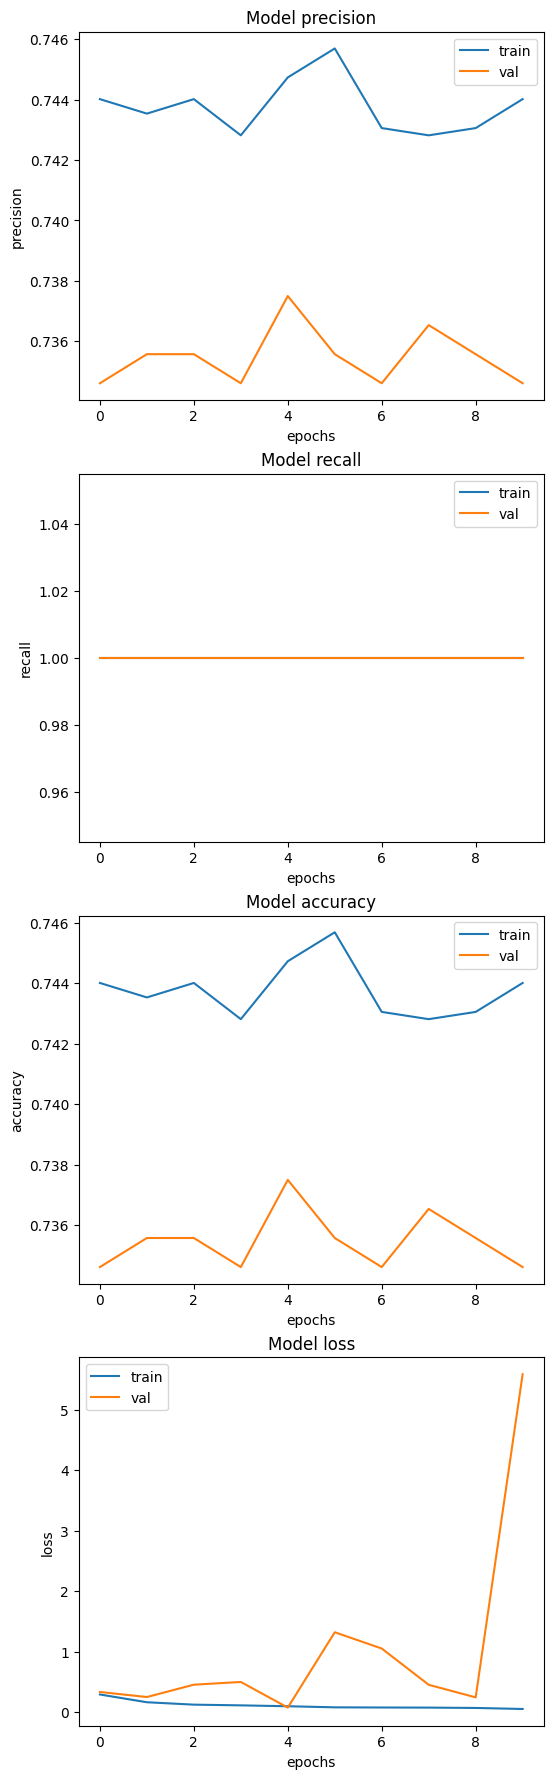

In [30]:
fig, ax = plt.subplots(4, 1, figsize=(6, 22))
ax = ax.ravel()

for i, k in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[k])
    ax[i].plot(history.history['val_' + k])
    ax[i].set_title('Model {}'.format(k))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(k)
    ax[i].legend(['train', 'val'])

In [31]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 94ms/step - loss: 4.0000 - accuracy: 0.6250 - precision: 0.6250 - recall: 1.0000
Loss: 3.9999635219573975,
Accuracy: 0.625,
Precision: 0.625,
Recall: 1.0


### batch size 16, 4 epochs, augmentation

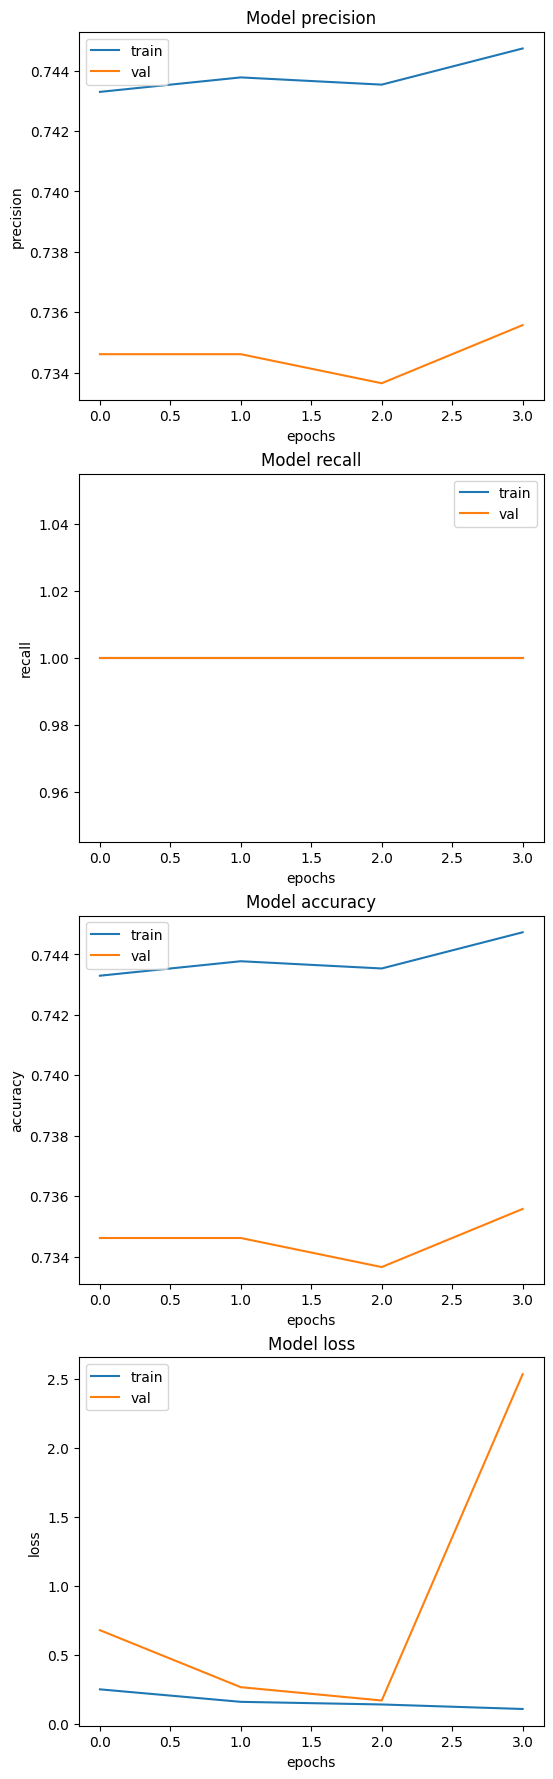

In [23]:
fig, ax = plt.subplots(4, 1, figsize=(6, 22))
ax = ax.ravel()

for i, k in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[k])
    ax[i].plot(history.history['val_' + k])
    ax[i].set_title('Model {}'.format(k))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(k)
    ax[i].legend(['train', 'val'])

In [24]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 3s 81ms/step - loss: 1.8007 - accuracy: 0.6250 - precision: 0.6250 - recall: 1.0000
Loss: 1.8007137775421143,
Accuracy: 0.625,
Precision: 0.625,
Recall: 1.0


### batch size 16, 10 epochs, no augmentation

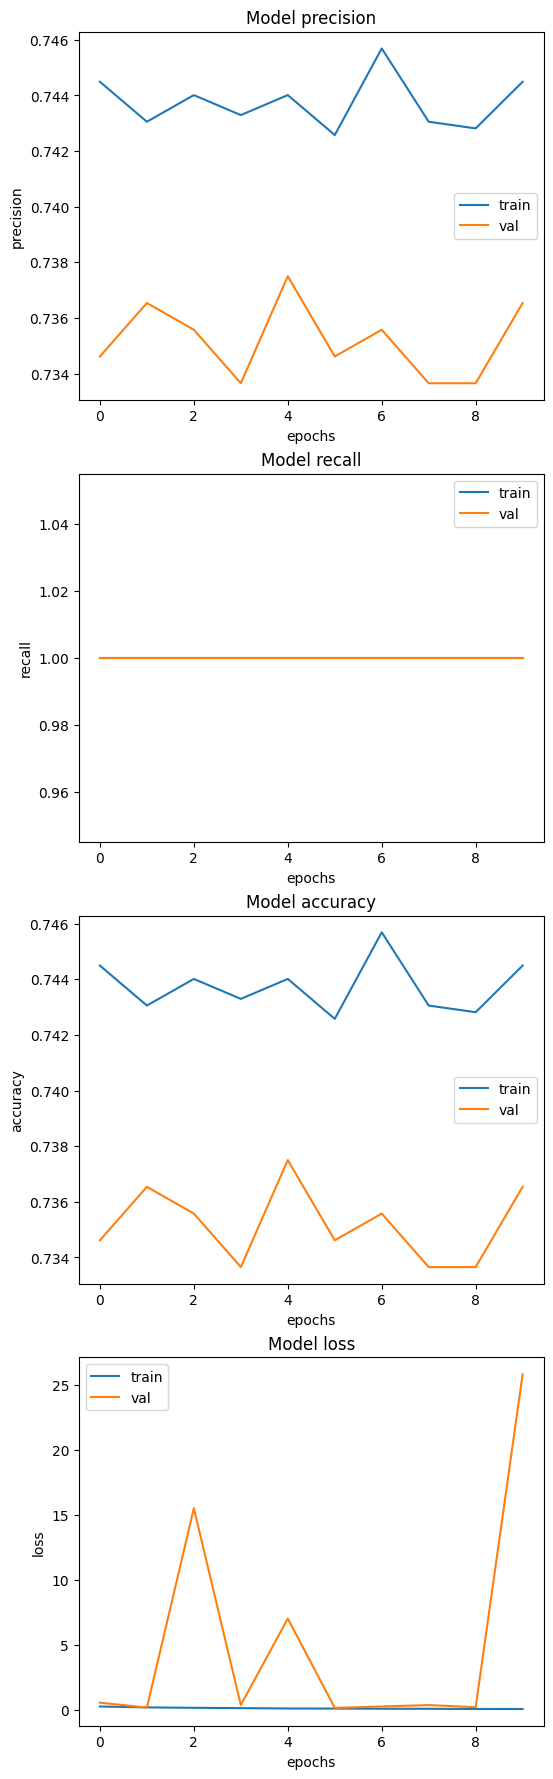

In [23]:
fig, ax = plt.subplots(4, 1, figsize=(6, 22))
ax = ax.ravel()

for i, k in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[k])
    ax[i].plot(history.history['val_' + k])
    ax[i].set_title('Model {}'.format(k))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(k)
    ax[i].legend(['train', 'val'])

In [24]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 3s 79ms/step - loss: 21.4983 - accuracy: 0.6250 - precision: 0.6250 - recall: 1.0000
Loss: 21.498294830322266,
Accuracy: 0.625,
Precision: 0.625,
Recall: 1.0


### batch size 16, 6 epochs, no augmentation

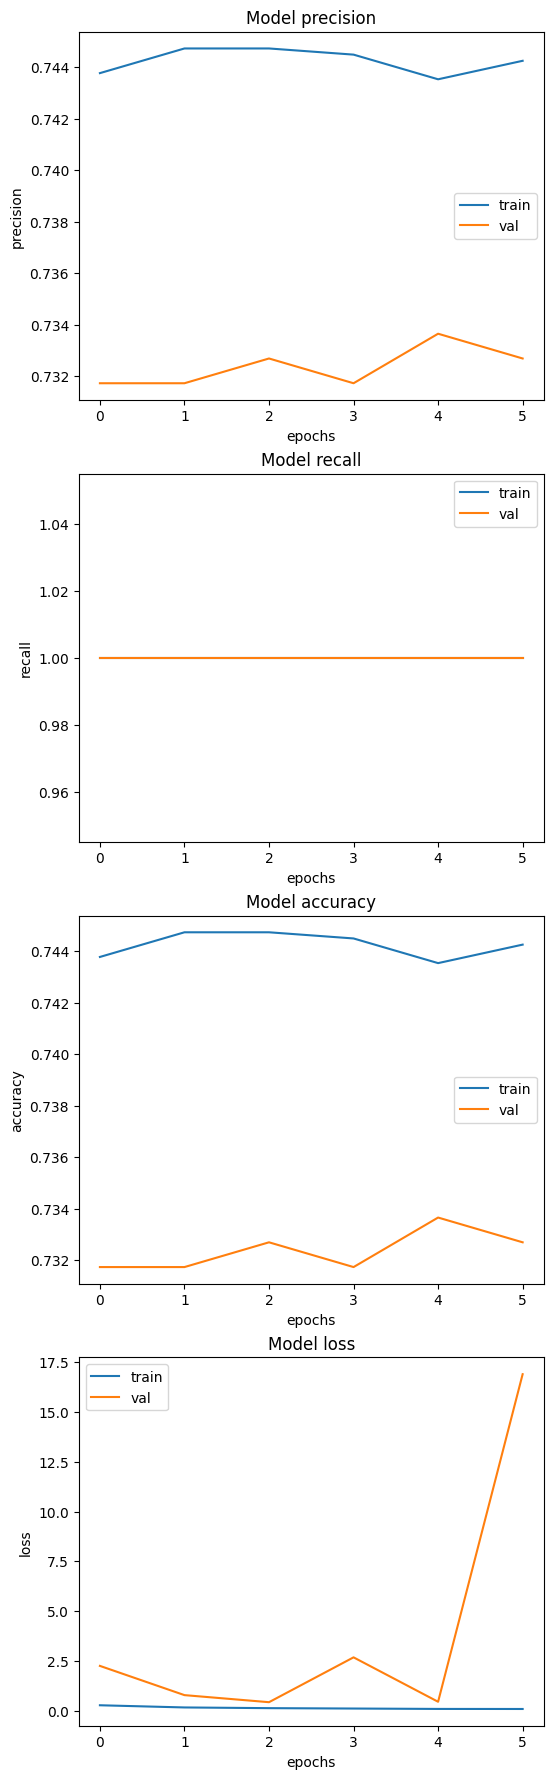

In [23]:
fig, ax = plt.subplots(4, 1, figsize=(6, 22))
ax = ax.ravel()

for i, k in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[k])
    ax[i].plot(history.history['val_' + k])
    ax[i].set_title('Model {}'.format(k))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(k)
    ax[i].legend(['train', 'val'])

In [24]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 3s 79ms/step - loss: 13.5013 - accuracy: 0.6250 - precision: 0.6250 - recall: 1.0000
Loss: 13.501347541809082,
Accuracy: 0.625,
Precision: 0.625,
Recall: 1.0


## 결론

### 루브릭

|평가문항|상세기준|
|:---|:---|
|1. 의료영상을 처리하는 CNN 기반 딥러닝 모델이 잘 구현되었다.|모델 학습이 안정적으로 수렴하는 것을 시각화를 통해 확인하였다.|
|2. 데이터 준비, 모델구성 등의 과정의 다양한 실험이 체계적으로 수행되었다.|regularization, augmentation 등의 기법의 사용 여부에 따른 모델 성능 측정이 ablation study 형태로 체계적으로 수행되었다.|
|3. 실습코드를 잘 개선하여 폐렴 검출 정확도가 추가로 향상되었다.|Accuracy 기준 85%에 도달하였다.|

### 고찰

어디가 문제인지 모르겠지만 agumentation 여부와 epoch 수를 변경했을 때 accuracy, precision, recall 값이 변하지 않았고 Loss값의 차이만 있었다. 4 epochs, 16 batch size, augmentation 적용했을 때 loss 1.8007137775421143로 가장 낮았으나 Accuracy 0.625로 기준 미달이었다. 전처리나 모델 구성을 점검해볼 필요가 있어 보인다. 또한, 더 많은 epochs나 다른 batch size에 대해서는 시도해보지 못해서 그에 따른 차이도 시도해야 할 과제인 것 같다.
시간이 더 있었다면 다양한 condition에서 모델을 학습시킬 수 있었을 것 같은데, 모델 구현 중 데이터 차원 관련 오류가 발생해 너무 많은 시간을 낭비했다. 모델도 다른 식으로 구성해 보고 전처리도 다시 진행해봤는데 결국 변수명 오류였다... 아쉬움이 많은 프로젝트지만 실수로 인해 많은 것을 찾아보면서, 특히 Resnet에 대해 이해할 수 있는 계기가 되었다.

### 회고
|KPT|내용|
|:---|:---|
|Keep|+ 시간 내에 모델을 구현하고 프로젝트를 마무리했다<br>+ 다양한 조건에서의 훈련을 진행하였다|
|Problem|+ 조정해볼 수 있는 다른 조건들에 대해 실험해보지 못했다<br>+ 조건을 변경해도 정확도의 변화가 없는 문제가 있었다<br>+ 정확도가 평가 기준에 한참 못 미쳤다|
|Try|+ 정확도를 올릴 수 있는 방법을 알아본다<br>+ 다른 조건에서의 모델 훈련을 시도한다<br>+ 전체적인 프로젝트 과정을 다시 점검한다|